# HPC 2022, ЛР1 MatMul, Одобеску Роман 6132
Данная ЛР посвящена реализации матричного умножения с использованием CUDA. В рамках данной ЛР также будет произведены сравнения следующих реализаций:
* на GPU (С++)
* на CPU (С++)
* на GPU через PyTorch (Python)
* на CPU через NumPy (Python)

Вся визуализация будет выполнена через Python. Данные для визуализации из C++ получаются путём копирования из вывода соответствующей ячейки.

# Установка nvcc

Проверка доступных GPU

In [1]:
!nvidia-smi

Mon Oct 10 12:58:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Установка nvcc плагина для Jupyter

In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-yotulkbq
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-yotulkbq
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done


In [3]:
%load_ext nvcc_plugin

directory /kaggle/working/src already exists
Out bin /kaggle/working/result.out


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


# Основная часть на С++

## Общие моменты:
* Все эксперименты выполнялись с усреднением по времени. Количество запусков регулируется переменной runs в функции main (repeats в функции exp)
* Числа в матрицах генерируются рандомно с помощью функции random_fill (генерация производится на хосте)
* Время считается внутри функций cpu_matmul и gpu_matmul
  
## Основные функции:  
* ### matmul_kernel  
 * Функция-ядро для матричного перемножения на GPU, вызывается в gpu_matmul. Каждый элемент результирующей матрицы считается в отдельной нити.  
 * Аргументы:   
int* matrix_1, int* matrix_2, int* res - указатели на первый, второй перемножаемый массивы и результирующий соответственно. Эти указатели должны ссылаться на области памяти девайса.  
int A, int B, int C - размерности массивов. Первый имеет размерность A * B, второй B * C, результирующий - A * C.  
 * Что возвращает: ничего.
* ### gpu_matmul  
 * Функция для матричного перемножения на GPU. Выполняет следующие функции: выделяет и освобождает память на девайсе, пересылает данные с хоста на девайс, вызывает функцию-ядро matmul_kernel и замеряет время.  
 * Аргументы: те же, что и в matmul_kernel, но указатели должны ссылаться на область памяти хоста, а не девайса.  
 * Что возвращает: время работы перемножения (считалось с помощью clock() на хосте).
* ### cpu_matmul  
 * Функция для матричного перемножения на CPU. Реализует классический алгоритм перемножения матриц и замеряет время.    
 * Аргументы: те же, что и в matmul_kernel, но указатели должны ссылаться на область памяти хоста, а не девайса.  
 * Что возвращает: время работы перемножения (считалось с помощью cudaEventElapsedTime на девайсе).

## Вспомогательные функции:
* random_fill - заполняет матрицу случайными числами
* err_check - проверяет, чтобы cudaError_t (который возвращает большинство cuda функций) был равен cudaSuccess, в ином случае выводит ошибку, произошедшую во время выполнения той или иной функции
* equals - проверка двух матриц на равенство
* exp - повторяет умножение несколько раз (для одних и тех же входных значений матрицы несколько раз генерируются и перемножаются), затем усредняет время


In [5]:
%%cu
#include <cstdio>
#include <iostream>
#include <ctime>
#include "assert.h"
using namespace std;

// Если cudaError_t, который вернула cuda-функция, не cudaSuccess, то выводит обнаруженную ошибку
void err_check(cudaError_t error){
    if (error != cudaSuccess){
        cout << "Error" << endl;
        cerr << cudaGetErrorString(error) << endl;
        exit(1);
    }
}


// Функция-ядро для матричного умножения на GPU (Классический алгоритм). Каждый элемент считается в своей нити
__global__ void matmul_kernel(int* matrix_1, int* matrix_2, int* res, int A, int B, int C){
     int row = blockIdx.y * blockDim.y + threadIdx.y;
     int col = blockIdx.x * blockDim.x + threadIdx.x;

     if (row < A && col < C){
         res[row * C + col] = 0;
         for (int i = 0; i < B; ++i) {
            res[row * C + col] += matrix_1[row * B + i] * matrix_2[i * C + col];
        }
     }
}


// Функция-обёртка для матричного умножения на GPU. Выделяет и освобождает память, пересылает данные, вызывает matmul_kernel и замеряет время
float gpu_matmul(int* matrix_1, int* matrix_2, int* res, int A, int B, int C){

    int matrix_1_size = A * B * sizeof(int);
    int matrix_2_size = B * C * sizeof(int);
    int res_size = A * C * sizeof(int);

    int* matrix_1_device;
    int* matrix_2_device;
    int* res_device;

    float all_time;
    cudaEvent_t start_event, end_event;

    // Выделение памяти на девайсе
    err_check(cudaMalloc(&matrix_1_device, matrix_1_size));
    err_check(cudaMalloc(&matrix_2_device, matrix_2_size));
    err_check(cudaMalloc(&res_device, res_size));

    // Пересылка данных с хоста на девайс
    err_check(cudaMemcpy(matrix_1_device, matrix_1, matrix_1_size, cudaMemcpyHostToDevice)); 
    err_check(cudaMemcpy(matrix_2_device, matrix_2, matrix_2_size, cudaMemcpyHostToDevice));

    // Ивенты для замера времени
    err_check(cudaEventCreate(&start_event));
    err_check(cudaEventCreate(&end_event));

    // BlockDim - размерность блока (здесь блок двумерный)
    dim3 blockDim(32, 32, 1); // Максимум 32*32 = 1024 нити в таком блоке
    
    int gridX = (C - 1) / blockDim.x + 1;
    int gridY = (A - 1) / blockDim.y + 1;
    
    // Размерность грида, в котором находятся блоки (здесь грид двумерный)
    dim3 gridDim(gridX, gridY, 1);

    // Старт отсчёта времени
    err_check(cudaEventRecord(start_event, 0));

    matmul_kernel<<<gridDim, blockDim>>>(matrix_1_device, matrix_2_device, res_device, A, B, C);

    // Конец отсчёта времени
    err_check(cudaEventRecord(end_event, 0));
    
    // Синхронизация девайса
    err_check(cudaDeviceSynchronize());

    // Подсчёт времени 
    err_check(cudaEventElapsedTime(&all_time, start_event, end_event));

    // Пересылка данных с девайса на хост
    err_check(cudaMemcpy(res, res_device, res_size, cudaMemcpyDeviceToHost));

    // Освобождение памяти на девайсе
    cudaFree(matrix_1_device);
    cudaFree(matrix_2_device);
    cudaFree(res_device);

    // Перевод времени в секунды
    return all_time / 1000;
}


// Матричное умножение на CPU (Классический алгоритм)
float cpu_matmul(int* matrix_1, int* matrix_2, int* res, int A, int B, int C){
    
    clock_t start, end;
    start = clock();

    for (int i = 0; i < A; ++i){
        for (int j = 0; j < C; ++j){
            int t = 0;
            for (int k = 0; k < B; ++k){
                t += matrix_1[i * B + k] * matrix_2[k * C + j];
            }
            res[i * C + j] = t;
        } 
    }

    end = clock();
    
    return 1.0f * (end - start) / CLOCKS_PER_SEC;
}


// Проверка двух матриц на равенство
bool equals(int* matrix_1, int* matrix_2, int A){
    bool flag = true;
    
    for (int i = 0; i < A; ++i){
      if (matrix_1[i] != matrix_2[i]){
          flag = false;
          break;
      }
  }

  return flag;
}


// Заполнение матрицы случайными значениями
void random_fill(int* mat, int A, int B){
  for (int i = 0; i < A * B; ++i){
      mat[i] = int(rand() % 32);
  }
}


// Функция для реализации эксперимента (один эксперимент - несколько запусков с усреднением времени)
void exp(int A, int B, int C, int repeats, float* cpu_t, float* gpu_t){
    
    *cpu_t = 0;
    *gpu_t = 0;
    
    // Выделение памяти под первый, второй перемножаемый массивы и под результирующие для cpu и gpu (всё выделяется на хосте)

    int* matrix_1 = (int*)malloc(A * B * sizeof(int));
    int* matrix_2 = (int*)malloc(B * C * sizeof(int));
    int* gpu_res = (int*)malloc(A * C * sizeof(int));
    int* cpu_res = (int*)malloc(A * C * sizeof(int));
    
    // Рандомное заполнение матриц (на хосте) и вызов cpu_matmul и gpu_matmul

    for (int repeat = 0; repeat < repeats; ++repeat){
        random_fill(matrix_1, A, B);
        random_fill(matrix_2, B, C);

        *cpu_t += cpu_matmul(matrix_1, matrix_2, cpu_res, A, B, C);
        *gpu_t += gpu_matmul(matrix_1, matrix_2, gpu_res, A, B, C);
        
        assert(equals(cpu_res, gpu_res, A * C));
    }
    
    // Усреднение по времени
    
    *cpu_t /= repeats;
    *gpu_t /= repeats;

    cout << "Avg CPU Time: " << *cpu_t << endl;
    cout << "Avg GPU Time: " << *gpu_t << endl;
    
    // Освобождение памяти на хосте
    
    free(matrix_1);
    free(matrix_2);
    free(gpu_res);
    free(cpu_res);
}


int main()
{
    // Фиксируем random seed для воспроизводимости. Почему 42?
    /*
    “All right,” said Deep Thought. “The Answer to the Great Question…”
    “Yes..!”
    “Of Life, the Universe and Everything…” said Deep Thought.
    “Yes…!”
    “Is…” said Deep Thought, and paused.
    “Yes…!”
    “Is…”
    “Yes…!!!…?”
    “Forty-two,” said Deep Thought, with infinite majesty and calm.”

    ―Douglas Adams, The Hitchhiker’s Guide to the Galaxy
    */
    srand(42);

    int exp_count = 10;
    int runs = 5;
    
    // A, B, C - размерности массивов (для каждого эксперимента)
    int* A = (int*)malloc(exp_count * sizeof(int));
    int* B = (int*)malloc(exp_count * sizeof(int));
    int* C = (int*)malloc(exp_count * sizeof(int));
    float* cpu_t = (float*)malloc(exp_count * sizeof(float));
    float* gpu_t = (float*)malloc(exp_count * sizeof(float));
    
    // Здесь происходит генерация размеров матриц для каждого эксперимента и их запуски
    for (int i = 0; i < exp_count; ++i){
        
        A[i] = 100*(i+1) + rand()%((i+1)*100) - rand()%((i+1)*50);
        B[i] = 100*(i+1) + rand()%((i+1)*100) - rand()%((i+1)*50);
        C[i] = 100*(i+1) + rand()%((i+1)*100) - rand()%((i+1)*50);

        //A[i] = B[i] = C[i] = 10 * (1 << i);

        cout << "A: " << A[i] << ",   B: " << B[i] << ",   C: " << C[i] << endl;
        exp(A[i], B[i], C[i], runs, cpu_t + i, gpu_t + i);
        cout  << endl;
    }

    // Вывод в виде dict для питона
    cout << endl;
    cout << "'A': ";
    cout << "[";
    for (int i = 0; i < exp_count; ++i){
        cout << A[i];
        if(i < exp_count-1){cout << ", ";}
    }
    cout << "]," << endl;

    cout << "'B': ";
    cout << "[";
    for (int i = 0; i < exp_count; ++i){
        cout << B[i];
        if(i < exp_count-1){cout << ", ";}
    }
    cout << "]," << endl;

    cout << "'C': ";
    cout << "[";
    for (int i = 0; i < exp_count; ++i){
        cout << C[i];
        if(i < exp_count-1){cout << ", ";}
    }
    cout << "]," << endl;

    cout << "'cpu_time': ";
    cout << "[";
    for (int i = 0; i < exp_count; ++i){
        cout << cpu_t[i];
        if(i < exp_count-1){cout << ", ";}
    }
    cout << "]," << endl;

    cout << "'gpu_time': ";
    cout << "[";
    for (int i = 0; i < exp_count; ++i){
        cout << gpu_t[i];
        if(i < exp_count-1){cout << ", ";}
    }
    cout << "]," << endl;
    
    // Освобождение выделенной памяти на хосте

    free(A);
    free(B);
    free(C);
    free(cpu_t);
    free(gpu_t);

    return 0;
}

A: 126,   B: 140,   C: 104
Avg CPU Time: 0.0051256
Avg GPU Time: 5.5552e-05

A: 247,   B: 381,   C: 333
Avg CPU Time: 0.0953054
Avg GPU Time: 0.00031513

A: 209,   B: 340,   C: 271
Avg CPU Time: 0.0573956
Avg GPU Time: 0.00021328

A: 464,   B: 379,   C: 715
Avg CPU Time: 0.535369
Avg GPU Time: 0.00097609

A: 287,   B: 408,   C: 515
Avg CPU Time: 0.199787
Avg GPU Time: 0.000664275

A: 643,   B: 629,   C: 839
Avg CPU Time: 1.43385
Avg GPU Time: 0.00257779

A: 483,   B: 986,   C: 971
Avg CPU Time: 2.0948
Avg GPU Time: 0.00391369

A: 594,   B: 819,   C: 1356
Avg CPU Time: 2.71472
Avg GPU Time: 0.0045433

A: 1408,   B: 919,   C: 1281
Avg CPU Time: 7.37024
Avg GPU Time: 0.0124198

A: 852,   B: 1553,   C: 1445
Avg CPU Time: 14.3332
Avg GPU Time: 0.0143646


'A': [126, 247, 209, 464, 287, 643, 483, 594, 1408, 852],
'B': [140, 381, 340, 379, 408, 629, 986, 819, 919, 1553],
'C': [104, 333, 271, 715, 515, 839, 971, 1356, 1281, 1445],
'cpu_time': [0.0051256, 0.0953054, 0.0573956, 0.535369, 0.19978

# Python (NumPy, PyTorch)

In [6]:
import torch
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

Квадратные матрицы

In [7]:
A = [10, 20, 40, 80, 160, 320, 640, 1280]
B = [10, 20, 40, 80, 160, 320, 640, 1280]
C = [10, 20, 40, 80, 160, 320, 640, 1280]

repeats = 5

In [8]:
time_list = list()

for i in range(len(A)):
    avg_time = 0
    for j in range(repeats):
        a = torch.rand((A[i], B[i]))
        b = torch.rand((B[i], C[i]))
        start = time.time()
        c = a @ b
        stop = time.time()
        avg_time += stop-start

    avg_time /= repeats
    time_list.append(avg_time)
    
print(f'\'pytorch_cpu_time\': {time_list}')

'pytorch_cpu_time': [0.0006746768951416016, 1.316070556640625e-05, 1.049041748046875e-05, 3.108978271484375e-05, 6.632804870605468e-05, 0.0007222652435302735, 0.003934097290039062, 0.030610990524291993]


In [9]:
time_list = list()

for i in range(len(A)):
    avg_time = 0
    for j in range(repeats):
        a = torch.rand((A[i], B[i])).to('cuda:0')
        b = torch.rand((B[i], C[i])).to('cuda:0')
        start = time.time()
        c = a @ b
        stop = time.time()
        avg_time += stop-start

    avg_time /= repeats
    time_list.append(avg_time)

print(f'\'pytorch_gpu_time\': {time_list}')

'pytorch_gpu_time': [0.0491145133972168, 8.916854858398437e-06, 9.012222290039062e-06, 8.821487426757812e-06, 1.0538101196289063e-05, 2.6464462280273438e-05, 2.4843215942382813e-05, 0.00012187957763671875]


In [10]:
time_list = list()

for i in range(len(A)):
    avg_time = 0
    for j in range(repeats):
        a = np.random.rand(A[i], B[i])
        b = np.random.rand(B[i], C[i])
        start = time.time()
        c = a @ b
        stop = time.time()
        avg_time += stop-start

    avg_time /= repeats
    time_list.append(avg_time)

print(f'\'numpy_time\': {time_list}')

'numpy_time': [3.428459167480469e-05, 6.532669067382812e-06, 1.583099365234375e-05, 0.0009394168853759765, 0.00029087066650390625, 0.0013185501098632812, 0.008018159866333007, 0.06698694229125976]


Прямоугольные матрицы

In [11]:
A = [126, 247, 209, 464, 287, 643, 483, 594, 1408, 852]
B = [140, 381, 340, 379, 408, 629, 986, 819, 919, 1553]
C = [104, 333, 271, 715, 515, 839, 971, 1356, 1281, 1445]

repeats = 5

In [12]:
time_list = list()

for i in range(len(A)):
    avg_time = 0
    for j in range(repeats):
        a = torch.rand((A[i], B[i]))
        b = torch.rand((B[i], C[i]))
        start = time.time()
        c = a @ b
        stop = time.time()
        avg_time += stop-start

    avg_time /= repeats
    time_list.append(avg_time)
    
print(f'\'pytorch_cpu_time\': {time_list}')

'pytorch_cpu_time': [0.0003890514373779297, 0.001183938980102539, 0.0007532596588134766, 0.003791475296020508, 0.0009588718414306641, 0.005003833770751953, 0.00689082145690918, 0.009747123718261719, 0.023297786712646484, 0.027376890182495117]


In [13]:
time_list = list()

for i in range(len(A)):
    avg_time = 0
    for j in range(repeats):
        a = torch.rand((A[i], B[i])).to('cuda:0')
        b = torch.rand((B[i], C[i])).to('cuda:0')
        start = time.time()
        c = a @ b
        stop = time.time()
        avg_time += stop-start

    avg_time /= repeats
    time_list.append(avg_time)

print(f'\'pytorch_gpu_time\': {time_list}')

'pytorch_gpu_time': [3.986358642578125e-05, 3.509521484375e-05, 2.09808349609375e-05, 2.3937225341796876e-05, 2.1409988403320312e-05, 4.329681396484375e-05, 3.981590270996094e-05, 4.6205520629882815e-05, 3.5715103149414065e-05, 7.185935974121093e-05]


In [14]:
time_list = list()

for i in range(len(A)):
    avg_time = 0
    for j in range(repeats):
        a = np.random.rand(A[i], B[i])
        b = np.random.rand(B[i], C[i])
        start = time.time()
        c = a @ b
        stop = time.time()
        avg_time += stop-start

    avg_time /= repeats
    time_list.append(avg_time)

print(f'\'numpy_time\': {time_list}')

'numpy_time': [0.0011675834655761718, 0.0014846324920654297, 0.0009588718414306641, 0.005413436889648437, 0.0023470401763916017, 0.011519479751586913, 0.014832496643066406, 0.021381282806396486, 0.05435886383056641, 0.06357297897338868]


# Визуализация на Python

## Квадратные матрицы

In [15]:
params = {
    'A':            [10, 20, 40, 80, 160, 320, 640, 1280],
    'B':            [10, 20, 40, 80, 160, 320, 640, 1280],
    'C':            [10, 20, 40, 80, 160, 320, 640, 1280],
    'cpu_time':     [3.8e-06, 2.26e-05, 0.0001818, 0.001422, 0.01124, 0.118544, 0.969015, 13.0672],
    'gpu_time':     [1.40928e-05, 1.6032e-05, 2.52544e-05, 3.91616e-05, 9.07776e-05, 0.000466144, 0.0030764, 0.029962],
    'pytorch_cpu_time': [3.01361083984375e-05, 7.343292236328125e-06, 1.1491775512695313e-05, 4.69207763671875e-05, 0.0002574920654296875, 0.0009653568267822266, 0.007341241836547852, 0.051343870162963864],
    'pytorch_gpu_time': [4.649162292480469e-05, 3.7288665771484376e-05, 3.366470336914062e-05, 3.976821899414063e-05, 4.892349243164062e-05, 4.487037658691406e-05, 7.700920104980469e-05, 0.00013580322265625],
    'numpy_time': [1.4162063598632812e-05, 7.915496826171876e-06, 1.7261505126953126e-05, 0.0008762359619140625, 0.001370716094970703, 0.0021053314208984374, 0.013567209243774414, 0.11188220977783203]
}

exp_count = len(params["A"])

Ячейка ниже строит интерактивные графики, но без подписей к осям :(  
Ниже будут неинтерактивные, но с осями

In [16]:
import plotly.graph_objects as go
data = []
for k in ['cpu_time', 'gpu_time', 'pytorch_cpu_time', 'pytorch_gpu_time', 'numpy_time']:
    plot = go.Scatter(x=params['A'],
                      y=params[k],
                      mode="lines+markers",
                      name=k
                     ) 
    data.append(plot)
fig = go.Figure(data=data)
fig.show()


data = []
for k in ['gpu_time', 'pytorch_cpu_time', 'pytorch_gpu_time', 'numpy_time']:
    plot = go.Scatter(x=params['A'],
                      y=params[k],
                      mode="lines+markers",
                      name=k
                     ) 
    data.append(plot)
fig = go.Figure(data=data)
fig.show()

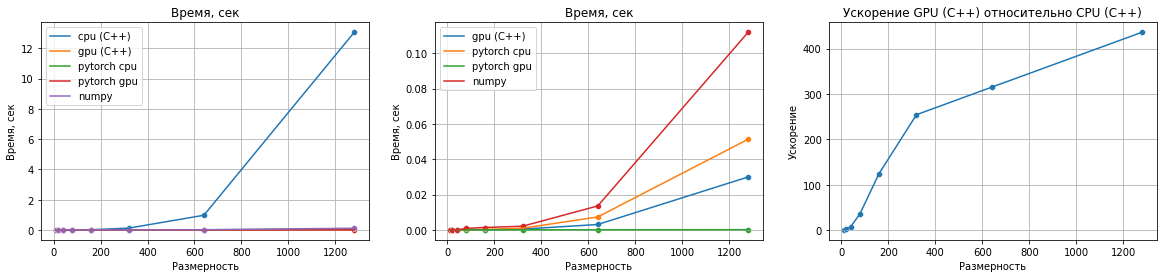

In [17]:
A = np.array(params['A'])
gpu_time = np.array(params['gpu_time'])
cpu_time = np.array(params['cpu_time'])
pytorch_cpu_time = np.array(params['pytorch_cpu_time'])
pytorch_gpu_time = np.array(params['pytorch_gpu_time'])
numpy_time = np.array(params['numpy_time'])

speed_ratio = cpu_time / gpu_time

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

axs[0].set_title("Время, сек")
axs[0].set_xlabel("Размерность")
axs[0].set_ylabel("Время, сек")
axs[0].grid()
sns.scatterplot(x=A, y=cpu_time, ax=axs[0])
sns.scatterplot(x=A, y=gpu_time, ax=axs[0])
sns.scatterplot(x=A, y=pytorch_cpu_time, ax=axs[0])
sns.scatterplot(x=A, y=pytorch_gpu_time, ax=axs[0])
sns.scatterplot(x=A, y=numpy_time, ax=axs[0])
sns.lineplot(x=A, y=cpu_time, ax=axs[0], label="cpu (C++)")
sns.lineplot(x=A, y=gpu_time, ax=axs[0], label="gpu (C++)")
sns.lineplot(x=A, y=pytorch_cpu_time, ax=axs[0], label="pytorch cpu")
sns.lineplot(x=A, y=pytorch_gpu_time, ax=axs[0], label="pytorch gpu")
sns.lineplot(x=A, y=numpy_time, ax=axs[0], label="numpy")

axs[1].set_title("Время, сек")
axs[1].set_xlabel("Размерность")
axs[1].set_ylabel("Время, сек")
axs[1].grid()
sns.scatterplot(x=A, y=gpu_time, ax=axs[1])
sns.scatterplot(x=A, y=pytorch_cpu_time, ax=axs[1])
sns.scatterplot(x=A, y=pytorch_gpu_time, ax=axs[1])
sns.scatterplot(x=A, y=numpy_time, ax=axs[1])
sns.lineplot(x=A, y=gpu_time, ax=axs[1], label="gpu (C++)")
sns.lineplot(x=A, y=pytorch_cpu_time, ax=axs[1], label="pytorch cpu")
sns.lineplot(x=A, y=pytorch_gpu_time, ax=axs[1], label="pytorch gpu")
sns.lineplot(x=A, y=numpy_time, ax=axs[1], label="numpy")

axs[2].set_title("Ускорение GPU (C++) относительно CPU (C++)")
axs[2].set_xlabel("Размерность")
axs[2].set_ylabel("Ускорение")
axs[2].grid()

sns.scatterplot(x=A, y=speed_ratio, ax=axs[2])
sns.lineplot(x=A, y=speed_ratio, ax=axs[2]);

Как можно заметить из графиков 1 и 2, самым долгим оказался простой алгоритм перемножения матриц на CPU (C++). Остальные же алгоритмы сравнимы по скорости между собой. Самым быстрым оказалось перемножение матриц на PyTorch с использованием GPU (что неудивительно, в DL операция довольно частая). На втором месте - собственная реализация перемножения на GPU (C++), третье место - PyTorch на CPU, и четвёртое - NumPy (CPU). Ускорение GPU (C++) относительно CPU (C++) увеличивается с увеличением размерности матрицы и при размерности 1280×1280 превышает 400 раз.

## Произвольный размер матриц

In [18]:
params = {
    'A': [126, 247, 209, 464, 287, 643, 483, 594, 1408, 852],
    'B': [140, 381, 340, 379, 408, 629, 986, 819, 919, 1553],
    'C': [104, 333, 271, 715, 515, 839, 971, 1356, 1281, 1445],
    'cpu_time': [0.0090696, 0.209696, 0.117167, 0.891641, 0.394457, 1.54412, 2.00503, 2.70457, 7.34898, 12.1159],
    'gpu_time': [6.9376e-05, 0.000670842, 0.000503616, 0.00237475, 0.00122159, 0.00635382, 0.00885308, 0.0106369, 0.0309608, 0.0361583],
    'pytorch_cpu_time': [0.0001369476318359375, 0.0014304637908935547, 0.0006725788116455078, 0.0035232067108154296, 0.0017145633697509765, 0.008199453353881836, 0.01255488395690918, 0.01672043800354004, 0.044394731521606445, 0.04952340126037598],
    'pytorch_gpu_time': [5.79833984375e-05, 7.600784301757813e-05, 4.6300888061523435e-05, 7.147789001464844e-05, 5.211830139160156e-05, 4.706382751464844e-05, 6.804466247558593e-05, 6.232261657714843e-05, 9.021759033203124e-05, 0.00010828971862792968],
    'numpy_time': [0.0009622573852539062, 0.0031732559204101563, 0.0013657569885253905, 0.007590198516845703, 0.0036208629608154297, 0.01963205337524414, 0.025281715393066406, 0.03933463096618652, 0.08678617477416992, 0.11843152046203613]
}

Ниже будут построены 3D-графики зависимости времени от A, B и C для всех сравниваемых алгоритмов. Время обозначается цветом, colorbar справа присутствует.   
Графики интерактивные, их можно зумить и изменять угол обзора, также при наведении на точку отобразится информация о ней.

In [19]:
for key in ["cpu_time", "gpu_time", "pytorch_cpu_time", "pytorch_gpu_time", "numpy_time"]:
    fig = px.scatter_3d(
    params, x='A', y='B', z='C',  color=key,
    size_max=20
    )
    fig.show()

Исходя из графиков выше можно сделать вывод, что практически у всех алгоритмов, за исключением, быть может, PyTorch (GPU), с увеличением количества элементов в массиве также увеличивалось время выполнения алгоритма. Такое странное поведение алгоритма PyTorch (GPU) можно объяснить тем, что его время работы настолько мало (на таких размерностях), что существенно начинает влиять асинхронность выполняемых нитей на GPU.